### Exercise on Sequential Minimal Optimization (SMO) Algorithm for SVM

- Following example on [this blog](https://www.codeproject.com/Articles/1267445/An-Introduction-to-Support-Vector-Machine-SVM-and) and [this blog](https://jonchar.net/notebooks/SVM/)
- [Notes on algorithm details](http://cs229.stanford.edu/materials/smo.pdf)


In [1]:
# load packages

import pandas as pd
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.preprocessing import StandardScaler

In [2]:
# define kernel functions

def linear(x, y, b=1):
    return x.dot(y.T) + b

def gaussian(x, y, sigma=1):
    if x.ndim == 1 and y.ndim == 1:
        # 1-d guassian function
        result = np.exp(-(np.linalg.norm(x-y), 2)**2 / (2*sigma**2))
        
    elif (x.ndim > 1 and y.ndim == 1) or (x.ndim ==1 and y.ndim > 1):
        # guassian function for when either input is more than 1-d
        result = np.exp(-(np.linalg.norm(x-y, 2, axis=1)**2) / (2*sigma**2))
    
    elif x.ndim > 1 and y.ndim > 1:
        # guassian function for both iputs are more than 1-d
        result = np.exp(-(np.linalg.norm(x[:, np.newaxis]-y[np.newaxis,:], 2, axis=2)**2) / (2*sigma**2))
    
    return result

In [3]:
x_vector = np.random.rand(5, 1)

linear(x_vector, x_vector)

array([[1.09471519, 1.25118909, 1.23411286, 1.05254752, 1.10390105],
       [1.25118909, 1.66616513, 1.62087817, 1.13935847, 1.27555042],
       [1.23411286, 1.62087817, 1.57866989, 1.12988466, 1.25681806],
       [1.05254752, 1.13935847, 1.12988466, 1.02915311, 1.05764379],
       [1.10390105, 1.27555042, 1.25681806, 1.05764379, 1.11397779]])

In [4]:
# define function for plotting decision boundary

def plot_decision_boundary(model, ax, resolution=100, colors=('b', 'k', 'r'), levels=(-1, 0, 1)):
    
    """Plots the model's decision boundary on the input axes object.
    Range of decision boundary grid is determined by the training data.
    Returns decision boundary grid and axes object (`grid`, `ax`)."""

    # Generate coordinate grid of shape [resolution x resolution]
    # and evaluate the model over the entire space
    xrange = np.linspace(model.X[:,0].min(), model.X[:,0].max(), resolution)
    yrange = np.linspace(model.X[:,1].min(), model.X[:,1].max(), resolution)
    grid = [[decision_function(model.alphas, model.y,
                               model.kernel, model.X,
                               np.array([xr, yr]), model.b) for xr in xrange] for yr in yrange]
    grid = np.array(grid).reshape(len(xrange), len(yrange))

    # Plot decision contours using grid and
    # make a scatter plot of training data
    ax.contour(xrange, yrange, grid, levels=levels, linewidths=(1, 1, 1),
               linestyles=('--', '-', '--'), colors=colors)
    ax.scatter(model.X[:,0], model.X[:,1],
               c=model.y, cmap=plt.cm.viridis, lw=0, alpha=0.25)

    # Plot support vectors (non-zero alphas)
    # as circled points (linewidth > 0)
    mask = np.round(model.alphas, decimals=2) != 0.0
    ax.scatter(model.X[mask,0], model.X[mask,1],
               c=model.y[mask], cmap=plt.cm.viridis, lw=1, edgecolors='k')

    return grid, ax

In [5]:
class SMO:
    
    def __init__(self, X, y, kernel, C=100.0, b=0.0, tol=0.01, eps=0.01):
        self.X = X # training data
        self.y = y # sample label
        self.C = C # regularizaiton factor
        self.kernel = kernel # kernel function
        self.alphas = np.zeros(X.shape[0]) # lagrange multipliers from the dual problem
        self.b = b # intercept of the decision plane
        self._obj = [] # history of objective function values
        self.m = self.X.shape[0] # size of the training set
        self.tol = tol
        self.eps = eps
        self.errors = self.decision(self.alphas, self.y, self.kernel, self.X, self.X, self.b) - self.y

    def obj_function(self, alphas, target, kernel, X_train):
    
        obj = np.sum(alphas) - 0.5 * np.sum((target[:, None] * target[None,:]) * kernel(X_train, X_train) * (alphas[:, None]*alphas[None,:]))
    
        return obj

    # define decision function

    def decision(self, alphas, target, kernel, X_train, X_test, b):
        return (alphas * target).dot(kernel(X_train, X_test)) - b
    
    def take_step(self, i1, i2):
        
        # this is the main function to compute the values of the 2 selected alphas
        
        # skip if the chose 2 alphas are the same
        if i1==i2:
            return 0
        
        alpha1 = self.alphas[i1]
        alpha2 = self.alphas[i2]
        y1 = self.y[i1]
        y2 = self.y[i2]
        E1 = self.errors[i1]
        E2 = self.errors[i2]
        s = y1 * y2
        
        # compute the lower & higher bounds (L & H) of the new possible values
        
        if y1 != y2:
            L = max(0, alpha2 - alpha1)
            H = min(self.C, self.C + alpha2 - alpha1)
        
        elif y1 == y2:
            L = max(0, alpha1 + alpha2 - self.C)
            H = min(self.C, alpha1 + alpha2)
        
        if L == H:
            return 0
        
        # compute kernel and 2nd derivative eta
        
        k11 = self.kernel(self.X[i1], self.X[i1])
        k12 = self.kernel(self.X[i1], self.X[i2])
        k22 = self.kernel(self.X[i2], self.X[i2])
        eta = 2 * k12 - k11 - k22
        
        # compute new alpha2 if eta is negative
        
        if eta < 0:
            # update alpha2 with the following rule
            a2 = alpha2 - y2 * (E1 - E2) / eta
            # clip a2 based on bounds L & H
            if L < a2 < H:
                a2 = a2
            elif a2 <= L:
                a2 = L
            elif a2 >= H:
                a2 = H
        
        # if eta >= 0, move new a2 to bound with greater obj function value
        else:
            alphas_adj = self.alphas.copy()
            
            # obj function with a2=L
            alphas_adj[i2] = L
            Lobj = self.obj_function(alphas_adj, self.y, self.kernel, self.X)
            # obj function with a2=H
            alphas_adj[i2] = H
            Hobj = self.obj_function(alphas_adj, self.y, self.kernel, self.X)
            
            if Lobj > (Hobj + self.eps):
                a2 = L
            elif Lobj < (Hobj - self.eps):
                a2 = H
            else:
                a2 = alpha2
                
        # push a2 to 0 or C if very close
        if a2 < 1e-8:
            a2 = 0.0
        elif a2>(self.C-1e-8):
            a2 = self.C
            
        # if already optimized, skip this pair
        if np.abs(a2 - alpha2) < self.eps * (a2 + alpha2 + self.eps):
            return 0
        
        # caluclate new alpha1
        a1 = alpha1 + s * (alpha2 - a2)
        
        # update tresholds b to reflect new alphas
        b1 = E1 + y1 * (a1 - alpha1) * k11 + y2 * (a2 - alpha2) * k12 + self.b
        b2 = E2 + y1 * (a1 - alpha1) * k12 + y2 * (a2 - alpha2) * k22 + self.b
        
        # set new thresholds based on whether a1 or a2 is bound by L / H
        if 0 < a1 and a1 < self.C:
            b_new = b1
        elif 0 < a2 and a2 < self.C:
            b_new = b2
        else:
            b_new = (b1 + b2) * 0.5
        
        # update alphas
        self.alphas[i1] = a1
        self.alphas[i2] = a2
        
        #update error cache
        for idx, alph in zip([i1, i2], [a1, a2]):
            if 0.0 < alph < self.C:
                self.errors[idx] = 0.0
        
        # set non-optimized errors
        non_opt = [n for n in range(self.m) if (n != i1 and n != i2)]
        self.errors[non_opt] = self.errors[non_opt] + \
                                y1 * (a1 - alpha1) * self.kernel(self.X[i1], self.X[non_opt]) +\
                                y2 * (a2 - alpha2) * self.kernel(self.X[i2], self.X[non_opt]) +\
                                self.b - b_new
        
        # update model threshold
        self.b = b_new
        
        return 1

    def examine(self, i2):
        
        # this function seaches to choose the 2nd alpha to optimize
        
        y2 = self.y[i2]
        alpha2 = self.alphas[i2]
        E2 = self.errors[i2]
        r2 = E2 * y2
        
        # continue if error is within tolerance
        if ((r2 < -self.tol) and (alpha2 < self.C)) or ((r2 > self.tol) and (alpha2 > 0)):
            
            if len(self.alphas[(self.alphas != 0) & (self.alphas != self.C)]) > 1:
                
                if self.errors[i2] > 0:
                    i1 = np.argmin(self.errors)
                elif self.errors[i2] <= 0:
                    i1 = np.argmax(self.errors)
                step_result = self.take_step(i1, i2)
                
                if step_result:
                    return 1
            
            # loop through non-zero and non-C alphas, starting at a random point
            for i1 in np.roll(np.where((self.alphas != 0) & (self.alphas != self.C))[0],
                             np.random.choice(np.arange(self.m))):
                step_result = self.take_step(i1, i2)
                if step_result:
                    return 1
            # loop through all alphas, starting at a random point
            for i1 in np.roll(np.arange(self.m), np.random.choice(np.arange(self.m))):
                step_result = self.take_step(i1, i2)
                if step_result:
                    return 1
        
        return 0
    
    def train(self):
        
        # this function selects the 1st alpha and passes it to the examine method
        
        num = 0
        examined = 1
        
        while (num > 0) or (examined):
            num = 0
            if examined:
                # loop through all examples
                for i in range(self.alphas.shape[0]):
                    examine_result = self.examine(i)
                    num += examine_result
                    if examine_result:
                        obj_result = self.obj_function(self.alphas, self.y, self.kernel, self.X)
                        self._obj.append(obj_result)
            
            else:
                # loop through examples where alphas are not at limt
                for i in np.where((self.alphas != 0) & (self.alphas != self.C))[0]:
                    examine_result = self.examine(i)
                    num += examine_result
                    if examine_result:
                        obj_result = self.obj_function(self.alphas, self.y, self.kernel, self.X)
                        self._obj.append(obj_result)
            
            if examined == 1:
                examined = 0
            elif num == 0:
                examined = 1

                
    # define function for plotting decision boundary

    def plot_decision_boundary(self, resolution=100, colors=('b', 'k', 'r'), levels=(-1, 0, 1)):
    
        fig, ax = plt.subplots()
        
        # Generate coordinate grid of shape [resolution x resolution]
        # and evaluate the model over the entire space
        xrange = np.linspace(self.X[:,0].min(), self.X[:,0].max(), resolution)
        yrange = np.linspace(self.X[:,1].min(), self.X[:,1].max(), resolution)
        grid = [[self.decision(self.alphas, self.y,
                                   self.kernel, self.X,
                                   np.array([xr, yr]), self.b) for xr in xrange] for yr in yrange]
        grid = np.array(grid).reshape(len(xrange), len(yrange))

        # Plot decision contours using grid and
        # make a scatter plot of training data
        ax.contour(xrange, yrange, grid, levels=levels, linewidths=(1, 1, 1),
                   linestyles=('--', '-', '--'), colors=colors)
        ax.scatter(self.X[:,0], self.X[:,1],
                   c=self.y, cmap=plt.cm.viridis, lw=0, alpha=0.25)

        # Plot support vectors (non-zero alphas)
        # as circled points (linewidth > 0)
        mask = np.round(self.alphas, decimals=2) != 0.0
        ax.scatter(self.X[mask,0], self.X[mask,1],
                   c=self.y[mask], cmap=plt.cm.viridis, lw=1, edgecolors='k')


In [18]:
X, y = make_blobs(n_samples=1000, centers=2, n_features=2, random_state=24)

In [19]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X, y)

In [20]:
y[y==0] = -1

In [21]:
model = SMO(X_scaled, y, C=1000.0, kernel=linear)

In [22]:
model.train()

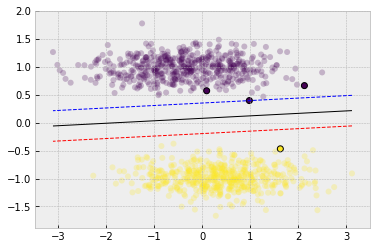

In [23]:
model.plot_decision_boundary()